### Liste des questions :

- Tracez les ventes quotidiennes pour les 50 semaines.
- Il semble qu'il y ait eu un changement soudain dans les ventes quotidiennes. À quelle date cela s'est-il produit ?
- Le changement dans les ventes quotidiennes à la date que vous avez sélectionnée est-il statistiquement significatif ? Si oui, quelle est la valeur p ?
- Les données suggèrent-elles que le changement dans les ventes quotidiennes est dû à une modification dans la proportion de clients hommes par rapport aux femmes ? Veuillez utiliser des graphiques pour étayer votre réponse (une analyse statistique rigoureuse n'est pas nécessaire).
- Supposons qu'une journée soit divisée en quatre plages horaires : nuit (00h00 - 06h00), matin (06h00 - 12h00), après-midi (12h00 - 18h00) et soir (18h00 - 00h00). Quel est le pourcentage des ventes dans chaque plage horaire sur l'ensemble des 50 semaines ?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt

#utile pour faire un t-test et récupérer la p-value
from scipy import stats

#### Importation des fichiers csv et intégration dans un dataframe

In [2]:
#Récupération de tous les fichiers
l = [pd.read_csv(filename) for filename in glob.glob("./datasetclients/Sales/*.csv")]

print(len(l))

50


In [3]:
df = pd.concat(l, axis=0)
df

,sale_time,purchaser_gender
0,2012-10-01 01:42:22,female
1,2012-10-01 02:24:53,female
2,2012-10-01 02:25:40,female
3,2012-10-01 02:30:42,female
4,2012-10-01 02:51:32,male
...,...,...
4994,2013-09-15 23:30:51,female
4995,2013-09-15 23:42:02,female
4996,2013-09-15 23:43:24,male
4997,2013-09-15 23:43:32,male


In [4]:
#Utilisation de df.info() pour vérifier si il y a des valeurs nulles et le type de données 
#(j'aurais pu utiliser isna mais j'ai ma réponse ici
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204329 entries, 0 to 4998
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   sale_time         204329 non-null  object
 1   purchaser_gender  204329 non-null  object
dtypes: object(2)
memory usage: 4.7+ MB


Le df.info() m'indique que j'ai 204329 lignes, et le même nombre est "non null", le dataset est donc bien rempli. Par contre la colonne sales_time est de type objet, je vais la changer en type date

In [19]:
df['sale_time'] = pd.to_datetime(df['sale_time'])

#### Il semblerait qu'il y ai un changement dans les ventes à partir d'un certain jour

Pour vérifier ça, je commence par un groupby pour récupérer la quantité de ventes par jours.
J'utiliserais ensuite ce tableau de données pour créer un lineplot

In [6]:
daily_sales = df['sale_time'].groupby(df['sale_time'].dt.floor('d')).size().reset_index(name="sales_amount")
daily_sales.head()

,sale_time,sales_amount
0,2012-10-01,514
1,2012-10-02,482
2,2012-10-03,499
3,2012-10-04,546
4,2012-10-05,476


<AxesSubplot:xlabel='sale_time', ylabel='sales_amount'>

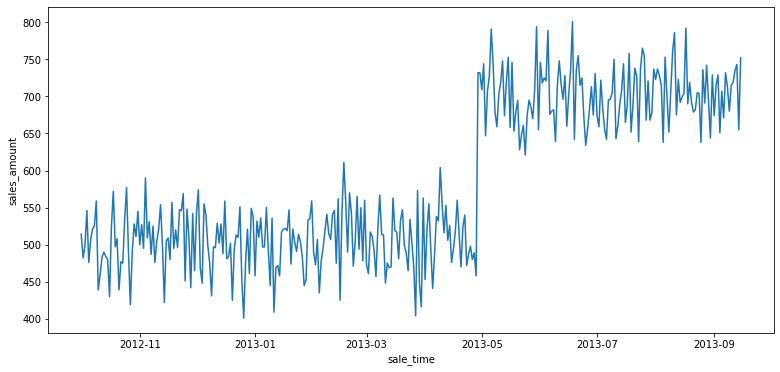

In [21]:
#Création du lineplot

plt.figure(figsize=(13, 6))
sns.lineplot(data=daily_sales, x='sale_time', y="sales_amount")

Le lineplot montre bien une évolution drastique des ventes autour d'Avril et de Mai 2013, mais on va chercher à être plus précis et récupérer la date où la plus haute évolution à eu lieu.

Pour ça trois étapes :
- Définir les ventes du jour antérieur
- Calculer les ventes du jour actuel moins les ventes antérieures
- Chercher le moment où l'évolution à été la plus haute et en sortir la date

In [32]:
#Récupération des différences entre les ventes des différents jours,
#ce qui va permettre de trouver le jour où il y a la plus grande différence

daily_sales["prev_day_sale"] = daily_sales['sales_amount'].shift(1)
daily_sales["difference_btw_prev"] = daily_sales["sales_amount"] - daily_sales["prev_day_sale"]
daily_sales.head()

,sale_time,sales_amount,prev_day_sale,difference_btw_prev
1,2012-10-02,482,NaN,NaN
2,2012-10-03,499,482.0,17.0
3,2012-10-04,546,499.0,47.0
4,2012-10-05,476,546.0,-70.0
5,2012-10-06,507,476.0,31.0


In [23]:
#Récupération de la différence maximale, et donc de la date associée

max_value = daily_sales['difference_btw_prev'].max()
df_max_value = daily_sales.loc[daily_sales.difference_btw_prev == max_value]

df_max_value

,sale_time,sales_amount,prev_day_sale,difference_btw_prev
210,2013-04-29,732,458.0,274.0


#### Calcul de la p-value

Pour ça, j'ai importé au préalable stats.
Le premier paramètre récupère toutes les ventes, et fait la comparaison avec la vente la plus haute


In [25]:
daily_sales.dropna(inplace=True)
stats.ttest_1samp(daily_sales['sales_amount'], df_max_value['sales_amount'])

Ttest_1sampResult(statistic=210   -26.273266
Name: sales_amount, dtype: float64, pvalue=array([1.30195933e-84]))

La valeur est largement en dessous de l'attente classique de 0.05
Ce qui signifie qu'il y a effectivement eu un très gros impact sur les ventes, et que ça ne semble pas dû au hasard.

#### Vérifions si cette évolution est due à une évolution de la proportion entre femme et homme dans les ventes

Je vais faire une copie du dataset, grouper les données par le jour de vente ainsi que le sexe de l'acheteur

In [26]:
gender_portion_df = df.copy()
gender_portion_df['sale_time'] = gender_portion_df['sale_time'].dt.floor('d')

gender_portions = gender_portion_df.groupby(['sale_time', 'purchaser_gender']).size().reset_index(name='sales_amount')
gender_portions

,sale_time,purchaser_gender,sales_amount
0,2012-10-01,female,413
1,2012-10-01,male,101
2,2012-10-02,female,379
3,2012-10-02,male,103
4,2012-10-03,female,386
...,...,...,...
695,2013-09-13,male,537
696,2013-09-14,female,193
697,2013-09-14,male,462
698,2013-09-15,female,230


Ensuite, je vais ajouter plusieurs colonnes :

- A nouveau le total des ventes, ça sera utile pour le graphique
- Le total de ventes des hommes pour cette journée
- Idem pour les femmes
- La proportion de ventes d'hommes vs femmes

In [27]:
new_df = pd.DataFrame(gender_portions['sale_time'].unique(),columns=['sale_time'])
new_df['male_sales'] = pd.Series(gender_portions[gender_portions.purchaser_gender == "male"]["sales_amount"]).reset_index(drop=True)
new_df['female_sales'] = pd.Series(gender_portions[gender_portions.purchaser_gender == "female"]["sales_amount"]).reset_index(drop=True)
new_df['proportion'] = new_df["male_sales"] / new_df["female_sales"]
new_df['total_sales'] = new_df["male_sales"] + new_df["female_sales"]

new_df

,sale_time,male_sales,female_sales,proportion,total_sales
0,2012-10-01,101,413,0.244552,514
1,2012-10-02,103,379,0.271768,482
2,2012-10-03,113,386,0.292746,499
3,2012-10-04,114,432,0.263889,546
4,2012-10-05,108,368,0.293478,476
...,...,...,...,...,...
345,2013-09-11,495,224,2.209821,719
346,2013-09-12,510,225,2.266667,735
347,2013-09-13,537,206,2.606796,743
348,2013-09-14,462,193,2.393782,655


Je vais ensuite créer un lineplot pour comparer l'évolution de la proportion d'homme aux ventes, pour voir si il y a une correlation.

Text(0.5, 1.0, 'Total Sales and Proportion Over Time')

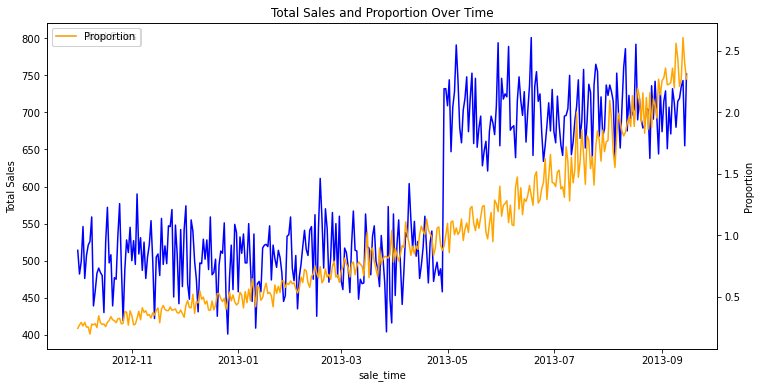

In [13]:
# Initialisation de la figure et des deux axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Tracer des ventes totales sur le premier axe (ax1)
sns.lineplot(data=new_df, x="sale_time", y="total_sales", ax=ax1, label="Total Sales", color="blue")
ax1.set_ylabel("Total Sales")

# Création du deuxième axe (ax2) qui partage le même axe x
ax2 = ax1.twinx()
sns.lineplot(data=new_df, x="sale_time", y="proportion", ax=ax2, label="Proportion", color="orange")
ax2.set_ylabel("Proportion")

# Personnalisation et ajout d'une légende
ax1.set_title("Total Sales and Proportion Over Time")

La proportion d'hommes évolue constamment et de manière plutôt linéaire par rapport aux ventes qui explosent d'un coup à partir d'avril/mai 2013. On peut donc dire que l'évolution de la proportion des hommes n'a aucun lien avec l'explosion des ventes

### Focus sur la dernière question

Définition des créneaux horaires de chaque transaction

In [14]:
df["sale_hour"] = df['sale_time'].dt.ceil('h').dt.hour

df.head()

,sale_time,purchaser_gender,sale_hour
0,2012-10-01 01:42:22,female,2
1,2012-10-01 02:24:53,female,3
2,2012-10-01 02:25:40,female,3
3,2012-10-01 02:30:42,female,3
4,2012-10-01 02:51:32,male,3


In [15]:
def get_daypart(sale_hour):
    if sale_hour >= 0 and sale_hour < 6:
        return "night"
    if sale_hour >= 6 and sale_hour < 12:
        return "morning"
    if sale_hour >= 12 and sale_hour < 18:
        return "afternoon"
    if sale_hour >= 18 and sale_hour < 24:
        return "evening"
    
df["daypart"] = df['sale_hour'].apply(get_daypart)

df.head()

,sale_time,purchaser_gender,sale_hour,daypart
0,2012-10-01 01:42:22,female,2,night
1,2012-10-01 02:24:53,female,3,night
2,2012-10-01 02:25:40,female,3,night
3,2012-10-01 02:30:42,female,3,night
4,2012-10-01 02:51:32,male,3,night


In [28]:
df_daypart = df.groupby('daypart').size().reset_index(name='day_part_sales_amount')

df_daypart['percentage'] = (df_daypart["day_part_sales_amount"] / df_daypart["day_part_sales_amount"].sum()) * 100

df_daypart

,daypart,day_part_sales_amount,percentage
0,afternoon,81159,39.719766
1,evening,53523,26.194520
2,morning,56080,27.445933
3,night,13567,6.639782


Ce dernier point indique que la majorité des ventes se font dans l'après midi, sinon le soir/matin